In [ ]:
from google.colab import drive
drive.mount('/rcnn_object_detection')

Drive already mounted at /rcnn_object_detection; to attempt to forcibly remount, call drive.mount("/rcnn_object_detection", force_remount=True).


In [ ]:
%ls '/rcnn_object_detection/MyDrive/RCNN/zip_dataset'

Airplanes_Annotations.zip  Images.zip


In [ ]:
import os,cv2,keras
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
path="/rcnn_object_detection/MyDrive/RCNN/unzip_dataset/Images"
annot="/rcnn_object_detection/MyDrive/RCNN/unzip_dataset/Airplanes_Annotations"

In [ ]:
#https://stackoverflow.com/questions/59709854/why-execute-time-is-less-when-i-set-the-useoptimized-false
# speed-up using multithreads
cv2.setUseOptimized(True);
#https://learnopencv.com/selective-search-for-object-detection-cpp-python/?__cf_chl_captcha_tk__=pmd_Cz7.J3Gk2qOCtiuQaXG4o0CGclK3YVO2JcdAWeYhmIw-1633834254-0-gqNtZGzNAxCjcnBszQj9
#create Selective Search Segmentation Object using default parameters
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def get_iou(bb1, bb2):
  # determine the (x, y)-coordinates of the intersection rectangle
  #Converts from (x1,y1,x2,y2) to (x,y,w,h) format
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']

  # xA = max(boxA[0], boxB[0])
	# yA = max(boxA[1], boxB[1])
	# xB = min(boxA[2], boxB[2])
	# yB = min(boxA[3], boxB[3])

  x_left = max(bb1['x1'], bb2['x1'])      # x_left   or   xA
  y_top = max(bb1['y1'], bb2['y1'])       # y_top    or   yA
  x_right = min(bb1['x2'], bb2['x2'])     # x_right  or   xB
  y_bottom = min(bb1['y2'], bb2['y2'])    # y_bottom or   xB

  if(x_right<x_left or y_bottom<y_top):
    return 0.0

  #area= length * width 
  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])


  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou
  # print('bb1 : ',bb1)
  # print('bb2 : ',bb2)

In [ ]:

train_images = []
train_labels = []



In [ ]:
cc=0
for e,i in enumerate(os.listdir(annot)):
  try:
    cc=cc+1
    if(cc>=450):  #####################################################
      break  ########################################################
    if i.startswith("airplane"):
      filename = i.split(".")[0]+".jpg"
      #print(e,filename)#############################################
      image = cv2.imread(os.path.join(path,filename))
      df = pd.read_csv(os.path.join(annot,i))
      gtvalues=[]
      for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
      # set input image on which we will run segmentation
      #Loop over the image folder and set each image one by one as the base for 
      #selective search using code ss.setBaseImage(image)
      ss.setBaseImage(image)
      # Switch to fast but low recall Selective Search method
      ss.switchToSelectiveSearchFast()
      ###########  Switch to high recall but slow Selective Search method
      ###########  ss.switchToSelectiveSearchQuality()
      
      # run selective search segmentation on input image
      #Initialising fast selective search and getting proposed regions 
      #using using code ss.switchToSelectiveSearchFast() and ssresults = ss.process()
      ssresults = ss.process()
      # create a copy of original image
      imout = image.copy()
      counter = 0
      falsecounter = 0
      flag = 0
      fflag = 0
      bflag = 0
      cnt=0
      for e,result in enumerate(ssresults):
        if(e<2000 and flag==0):###########################################
          #print('result : ',result)
          #if(e<10 and flag==0):#############################################
          #for e,i in enumerate(os.listdir(annot)),,e=0,tokhon j pic ta asbe seitate 12 ta airplane ase,tai 12 ta bounding box ase
          #ai jonno same result 12 bar print hobe,,,,, e=0 hole gtvalues a 12 ta airplane er bounding box ase
          for gtval in gtvalues:
            #print('gtval : ',gtval)
            x,y,w,h=result
            #gtval er form a nite {"x1":x,"x2":x+w,"y1":y,"y2":y+h} koresi
            #Iterating over all the first 2000 results passed by selective search and calculating IOU of the
            # proposed region and annotated region using the get_iou() function created above.
            iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
            cnt=cnt+1
            if (counter<30):
              if (iou>0.7):
                #https://colab.research.google.com/drive/1aLd6Fww0emdan82wb5ImMCIbIR4JukjM#scrollTo=EIvzm-WbbHDn
                #https://www.geeksforgeeks.org/cropping-faces-from-images-using-opencv-python/
                # sudu airplane er portion mane onekta bounding box er moto portion tuku crop korlam
                timage=imout[y:y+h, x:x+w]
                #cv2_imshow(timage)###############################################################
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                #cv2_imshow(resized)##############################################################

                train_images.append(resized)
                train_labels.append(1)
                counter=counter+1
            else:
              # for-ground flag mane holo 100% sure joto tuku portion signed koresi
              fflag=1

            if (falsecounter<30):
              if (iou<0.3):
                timage=imout[y:y+h, x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                train_images.append(resized)
                train_labels.append(0)
                falsecounter=falsecounter+1

            else :
              #backgroung flag
              bflag=1

        if (fflag == 1 and bflag == 1):
          #print('inside fflag and bflag')####################################
          flag = 1
            
            #print('iou : ',iou)
            #print('x : ',x,"  y : ",y,"   w : ",w,"     h : ",h)
            #print('##########################################################')

      print('cnt : ',cnt)######################################################

  except Exception as e:
    print(e)
    print("error in "+filename)
    continue
    

cnt :  4176
cnt :  244
cnt :  557
cnt :  972
cnt :  748
cnt :  1099
cnt :  1960
cnt :  1068
cnt :  1386
cnt :  249
cnt :  452
cnt :  3124
cnt :  1002
cnt :  224
cnt :  290
cnt :  163
cnt :  540
cnt :  2952
cnt :  1392
cnt :  2289
cnt :  1960
cnt :  372
cnt :  467
cnt :  219
cnt :  957
cnt :  1650
cnt :  2530
cnt :  1572
cnt :  1156
cnt :  4977
cnt :  1162
cnt :  3426
cnt :  1156
cnt :  222
cnt :  1780
cnt :  399
cnt :  2736
cnt :  1064
cnt :  1210
cnt :  1392
cnt :  473
cnt :  321
cnt :  848
cnt :  622
cnt :  12064
cnt :  656
cnt :  20072
cnt :  870
cnt :  357
cnt :  792
cnt :  183
cnt :  402
cnt :  1470
cnt :  2114
cnt :  1685
cnt :  1824
cnt :  676
cnt :  1184
cnt :  1688
cnt :  1554
cnt :  378
cnt :  490
cnt :  2013
cnt :  267
cnt :  1148
cnt :  699
cnt :  798
cnt :  599
cnt :  1278
cnt :  738
cnt :  933
cnt :  2800
cnt :  71
cnt :  4060
cnt :  1292
cnt :  1115
cnt :  362
cnt :  2370
cnt :  1792
cnt :  154
cnt :  658
cnt :  914
cnt :  480
cnt :  279
cnt :  1722
cnt :  1686
cnt :  11

In [ ]:

X_new = np.array(train_images)
y_new = np.array(train_labels)


In [ ]:

from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [ ]:
#https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

#Here in this part I will import VGG16 from keras with pre-trained weights which was 
#trained on imagenet. Here as you can see that include top parameter is set to true. 
#This means that weights for our whole model will be downloaded. If this is set to false 
#then the pre-trained weights will only be downloaded for convolution layers and 
#no weights will be downloaded for dense layers.

vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()


In [ ]:
# plot the model architecture using plot_model function 
plot_model(vggmodel,
           to_file='mode.png',
           show_shapes=True,
           show_layer_names=True,
           )

In [ ]:
#https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

#In this part in the loop we are freezing(do false) the first 15 layers of the model
for layers in (vggmodel.layers)[:15]:
  print(layers)
  layers.trainable = False

In [ ]:
#https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

#After that we are taking out the second last layer of the model and then adding a 2 unit 
#softmax dense layer as we have just 2 classes to predict i.e. foreground or background.(see plot model)

X= vggmodel.layers[-2].output
print('vggmodel.layers[-2].output : \n',X)
predictions = Dense(2, activation="softmax")(X)
print('predictions : ',predictions)


In [ ]:
##################### Model ##################################


#input and output er sathe s add korbo otherwisw error khabo
model_final = Model(inputs = vggmodel.input, 
                    outputs = predictions
                    )
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


In [ ]:
####################   compile the Model    ###############################

model_final.compile(
    loss = keras.losses.categorical_crossentropy,
     optimizer = opt,
      metrics=["accuracy"]
      )


In [ ]:
model_final.summary()

In [ ]:
# plot the model architecture using plot_model function 
plot_model(vggmodel,
           to_file='mode.png',
           show_shapes=True,
           show_layer_names=True,
           )

In [ ]:
#https://newbedev.com/sklearn-labelbinarizer-returns-vector-when-there-are-2-classes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
#y_new = np.array(train_labels)
#train_labels will contain all the labels marking airplane images as 1 and non airplane images 
#(i.e. background images) as 0.
y_new

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
print("lenc.fit_transform(y_new) ##################################  : \n",Y)

In [ ]:
#   X_new = np.array(train_images)

X_train, X_test , y_train, y_test = train_test_split(
    X_new,
    Y,
    test_size=0.10
    )

In [ ]:

trdata = ImageDataGenerator(
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=90
    )

traindata = trdata.flow(
    x=X_train, 
    y=y_train
    )

In [ ]:

tsdata = ImageDataGenerator(
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=90
    )

testdata = tsdata.flow(
    x=X_test, 
    y=y_test
    )

In [ ]:
#https://colab.research.google.com/drive/16FspkI3ZP3v_Ed1A--8Tj42Fl73YsaHC#scrollTo=brWJCdhHP0EU
#https://www.markiiisys.com/blog/keras-modelcheckpoint-callback-yet-another-great-one/

ieeercnn_vgg16_1_h5="/rcnn_object_detection/MyDrive/RCNN/saved RCNN model/ieeercnn_vgg16_1.h5"
checkpoint = ModelCheckpoint(
    ieeercnn_vgg16_1_h5, 
    #The model will only be saved to disk if the validation accuracy of the model 
    #in current epoch is greater than what it was in the last epoch.
    monitor='val_accuracy', 
    verbose=1, 
    # Save weights, every epoch.
    #save_freq='epoch',
    #If the value is set True & you specify it to monitor loss, it will check the loss after every epoch
    #If the loss went down, then it will save that model.  If it didn't go down, it won't save it.
    save_best_only=True, 
    #If save_weights_only is set to True, only the weights are saved, not the model topology.  
    #If set to False, it saves the weights as well as the model topology.
    save_weights_only=False, 
    # I'll share a secret.  You can use auto and Keras is smart enough to know that with loss,
    # it should use min and with accuracy it should use max.
    mode='auto', 
    SAVE_PERIOD =10

    #if use period=1, WARNING:tensorflow:`period` argument is deprecated.Please use `save_freq` to specify the frequency
    #period=1
    )

In [ ]:
#https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd
#And here is an example of a customized early stopping:

early = EarlyStopping(
    #validation accuracy as performance measure to terminate the training.
    #The model will only be saved to disk if the validation accuracy of the model 
    #in current epoch is greater than what it was in the last epoch.
    monitor='val_accuracy', 
    #validation accuracy has to improve by at least 0 for it to count as an improvement
    min_delta=0, 
    # means the training is terminated as soon as 20 epochs with no improvement.
    patience=20, 
    verbose=1, 
    #the direction is automatically inferred from the name of the monitored quantity.
    mode='auto')

In [ ]:
#Now we start the training of the model using fit_generator.


hist = model_final.fit_generator(
    generator= traindata, 
    steps_per_epoch= 10, 
    epochs= 5, 
    validation_data= testdata, 
    validation_steps=2, 
    callbacks=[checkpoint,early]
    )


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
10/10 [==============================] - 124s 13s/step - loss: 0.6153 - accuracy: 0.7312 - val_loss: 0.4931 - val_accuracy: 0.8125

Epoch 00001: val_accuracy improved from 0.70312 to 0.81250, saving model to /rcnn_object_detection/MyDrive/RCNN/saved RCNN model/ieeercnn_vgg16_1.h5
Epoch 2/5
10/10 [==============================] - 126s 13s/step - loss: 0.5237 - accuracy: 0.7875 - val_loss: 0.6554 - val_accuracy: 0.6406

Epoch 00002: val_accuracy did not improve from 0.81250
Epoch 3/5
10/10 [==============================] - 123s 12s/step - loss: 0.5184 - accuracy: 0.7531 - val_loss: 0.6122 - val_accuracy: 0.8438

Epoch 00003: val_accuracy improved from 0.81250 to 0.84375, saving model to /rcnn_object_detection/MyDrive/RCNN/saved RCNN model/ieeercnn_vgg16_1.h5
Epoch 4/5
10/10 [==============================] - 127s 13s/step - loss: 0.4886 - accuracy: 0.7906 - val_loss: 0.4314 - val_accuracy: 0.8281

Epoch 00004: val_accuracy did not improve from 0.84375
Epoch 5/5
10/10 [=======

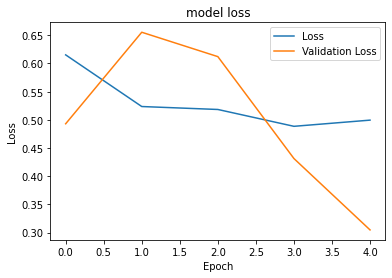

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

not plane


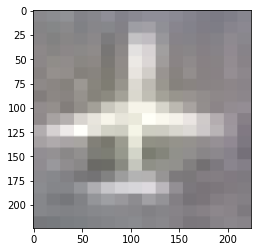

In [ ]:
im = X_test[14]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

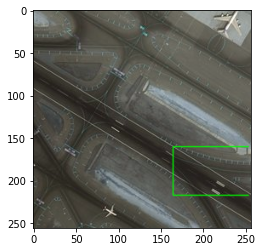

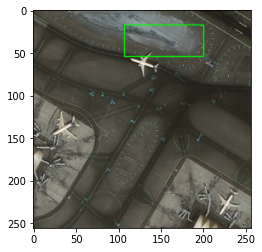

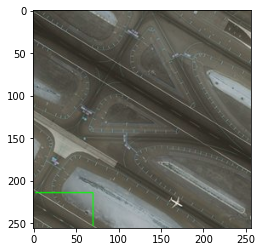

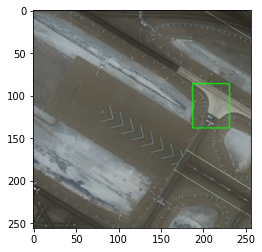

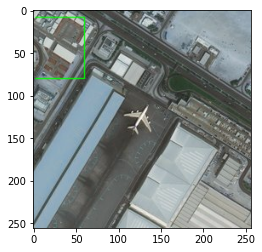

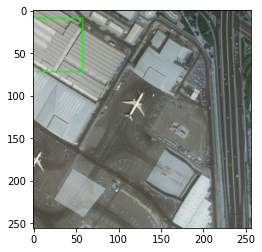

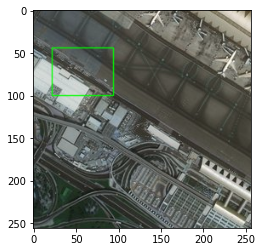

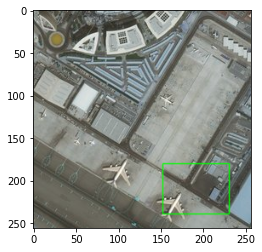

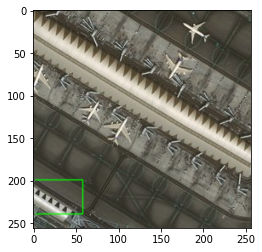

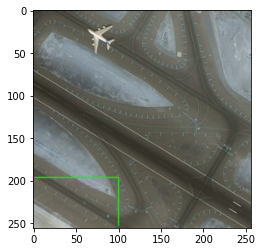

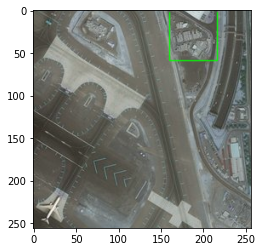

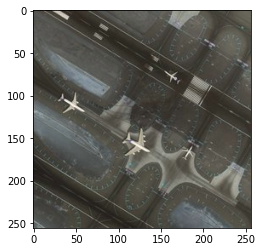

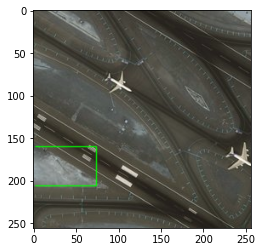

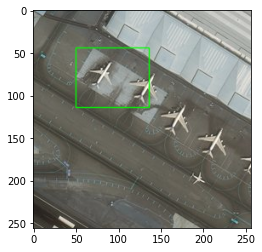

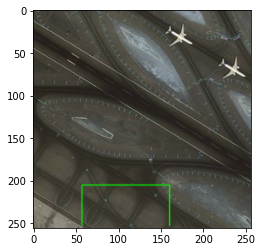

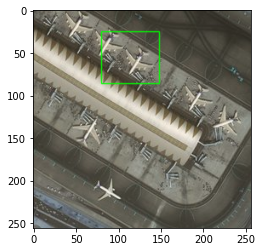

In [ ]:

z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                    break
        plt.figure()
        plt.imshow(imout)